In [1]:
import sys
print("Python executable:", sys.executable)

# Install packages into whatever environment this kernel is actually using
!{sys.executable} -m pip install matplotlib pandas tqdm opencv-python scikit-image nibabel h5py==3.7.0

Python executable: /DATA/hazellim/anaconda3/envs/graf/bin/python


In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import json

class UCSFPreprocessor:
    """
    Preprocess UCSF-BMSR for Lesion-Aware MedNeRF
    """
    
    def __init__(self, input_dir, output_dir, target_size=128, use_subtraction=True, 
                 use_clahe=False, use_lesion_boundaries=False):
        """
        Args:
            input_dir: Path to UCSF_BrainMetastases_TRAIN
            output_dir: Where to save processed data
            target_size: Output image size
            use_subtraction: Use subtraction images (T1post-T1pre) for better lesion contrast
        """
        self.input_dir = Path(input_dir)
        self.output_dir = Path(output_dir)
        self.target_size = target_size
        self.use_subtraction = use_subtraction
        self.use_clahe = use_clahe
        self.use_lesion_boundaries = use_lesion_boundaries
        
        # Create output directories
        (self.output_dir / 'images').mkdir(parents=True, exist_ok=True)
        (self.output_dir / 'masks').mkdir(parents=True, exist_ok=True)
        
    def load_nifti(self, filepath):
        """Load NIfTI file and return numpy array"""
        nii = nib.load(str(filepath))
        data = nii.get_fdata()
        return data, nii.affine
    
    def select_informative_slices(self, volume, segmentation, min_brain_ratio=0.3):
        """
        Select slices that contain brain tissue and optionally lesions
        
        Returns: list of slice indices
        """
        informative_slices = []
        n_slices = volume.shape[2]
        
        for i in range(n_slices):
            slice_vol = volume[:, :, i]
            slice_seg = segmentation[:, :, i]
            
            # Check if slice has enough brain tissue (non-zero voxels)
            brain_ratio = (slice_vol > 0).sum() / slice_vol.size
            
            if brain_ratio > min_brain_ratio:
                # Prioritize slices with lesions, but keep all brain slices
                has_lesion = slice_seg.sum() > 0
                informative_slices.append({
                    'idx': i,
                    'has_lesion': has_lesion,
                    'lesion_voxels': int(slice_seg.sum()),
                    'brain_ratio': float(brain_ratio)
                })
        
        return informative_slices
    
    def normalize_intensity(self, image):
        """Normalize to [0, 1] with robust scaling"""
        # Use percentiles to handle outliers
        p2, p98 = np.percentile(image[image > 0], [2, 98])
        
        # Clip and normalize
        image_norm = np.clip(image, p2, p98)
        if p98 > p2:
            image_norm = (image_norm - p2) / (p98 - p2)
        else:
            image_norm = np.zeros_like(image)
        
        return image_norm
    
    def contrast_enhancement(self, image):
        image_uint8 = (image * 255).astype(np.uint8)
        # gentler CLAHE
        clahe = cv2.createCLAHE(
            clipLimit=1.0,         # lower clip limit
            tileGridSize=(32, 32)  # larger tiles → smoother
        )
        enhanced = clahe.apply(image_uint8)
        return enhanced.astype(np.float32) / 255.0

    
    def generate_drr_projection(self, image):
        """
        Simulate X-ray attenuation (Iddrisu et al.)
        DRR = 1 - exp(-μ * intensity)
        """
        mu = 0.5  # attenuation coefficient
        drr = 1 - np.exp(-mu * image)
        return drr
    
    def enhance_lesion_boundaries(self, image, mask):
        """
        Lesion-aware enhancement: sharpen boundaries
        """
        if mask.sum() == 0:
            return image
        
        # Compute lesion boundary
        kernel = np.ones((3,3), np.uint8)
        dilated = cv2.dilate(mask.astype(np.uint8), kernel, iterations=2)
        boundary = (dilated - mask) > 0
        
        # Enhance boundary intensity
        image_enhanced = image.copy()
        image_enhanced[boundary] = np.clip(image_enhanced[boundary] * 1.3, 0, 1)
        
        return image_enhanced
    
    def _process_slice_core(self, img_slice, mask_slice):
        """
        Core pipeline used by BOTH process_patient and process_single_slice.
        Returns: img_norm, img_resized, img_drr, mask_binary
        """
        # normalize
        img_norm = self.normalize_intensity(img_slice)

        # resize
        img_resized = cv2.resize(
            img_norm,
            (self.target_size, self.target_size),
            interpolation=cv2.INTER_CUBIC
        )
        mask_resized = cv2.resize(
            mask_slice,
            (self.target_size, self.target_size),
            interpolation=cv2.INTER_NEAREST
        )
        mask_binary = (mask_resized > 0).astype(np.float32)

        # optional CLAHE
        img_proc = img_resized
        if self.use_clahe:
            img_proc = self.contrast_enhancement(img_proc)

        # optional lesion-boundary enhancement
        if self.use_lesion_boundaries:
            img_proc = self.enhance_lesion_boundaries(img_proc, mask_binary)

        # DRR
        img_drr = self.generate_drr_projection(img_proc)

        return img_norm, img_resized, img_drr, mask_binary

    
    def process_patient(self, patient_dir):
        """Process one patient's scan"""
        patient_id = patient_dir.name
        
        try:
            # Load volumes
            if self.use_subtraction and (patient_dir / f'{patient_id}_subtraction.nii.gz').exists():
                # Subtraction shows lesions best (T1post - T1pre)
                volume, affine = self.load_nifti(patient_dir / f'{patient_id}_subtraction.nii.gz')
            else:
                # Fall back to T1post
                volume, affine = self.load_nifti(patient_dir / f'{patient_id}_T1post.nii.gz')
            
            # Load segmentation
            seg, _ = self.load_nifti(patient_dir / f'{patient_id}_seg.nii.gz')
            
            # Select informative slices
            slices_info = self.select_informative_slices(volume, seg)
            
            if len(slices_info) == 0:
                return []
            
            processed_slices = []
            
            """
            for slice_info in slices_info:
                idx = slice_info['idx']
                
                # Extract 2D slice
                img_slice = volume[:, :, idx]
                mask_slice = seg[:, :, idx]
                
                # Normalize intensity
                img_norm = self.normalize_intensity(img_slice)
                
                # Resize to target size
                img_resized = cv2.resize(img_norm, (self.target_size, self.target_size), 
                                        interpolation=cv2.INTER_CUBIC)
                mask_resized = cv2.resize(mask_slice, (self.target_size, self.target_size),
                                         interpolation=cv2.INTER_NEAREST)
                
                # Binary mask (any metastasis = 1)
                mask_binary = (mask_resized > 0).astype(np.float32)
                
                # Contrast enhancement
                img_enhanced = self.contrast_enhancement(img_resized)
                #img_enhanced = img_resized.copy()
                
                # Lesion-aware boundary enhancement
                img_lesion_aware = self.enhance_lesion_boundaries(img_enhanced, mask_binary)
                
                # Generate DRR-style projection
                img_drr = self.generate_drr_projection(img_lesion_aware)
                
                # Save
                img_filename = f'{patient_id}_slice_{idx:03d}.png'
                mask_filename = f'{patient_id}_slice_{idx:03d}_mask.png'
                
                # Convert to RGB
                img_rgb = (np.clip(img_drr, 0, 1) * 255).astype(np.uint8)
                img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
                
                # Save image and mask
                cv2.imwrite(str(self.output_dir / 'images' / img_filename), img_rgb)
                
                mask_uint8 = (mask_binary * 255).astype(np.uint8)
                cv2.imwrite(str(self.output_dir / 'masks' / mask_filename), mask_uint8)
                
                # Record metadata
                processed_slices.append({
                    'patient_id': patient_id,
                    'slice_idx': idx,
                    'image_path': f'images/{img_filename}',
                    'mask_path': f'masks/{mask_filename}',
                    'has_lesion': slice_info['has_lesion'],
                    'lesion_voxels': slice_info['lesion_voxels'],
                    'brain_ratio': slice_info['brain_ratio'],
                    'lesion_ratio': float(mask_binary.sum() / (self.target_size ** 2))
                })
                """
            for slice_info in slices_info:
                idx = slice_info['idx']

                img_slice = volume[:, :, idx]
                mask_slice = seg[:, :, idx]

                img_norm, img_resized, img_drr, mask_binary = self._process_slice_core(
                    img_slice, mask_slice
                )

                img_filename = f'{patient_id}_slice_{idx:03d}.png'
                mask_filename = f'{patient_id}_slice_{idx:03d}_mask.png'

                img_to_save = img_resized      

                img_rgb = (np.clip(img_to_save, 0, 1) * 255).astype(np.uint8)
                img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)

                cv2.imwrite(str(self.output_dir / 'images' / img_filename), img_rgb)

                mask_uint8 = (mask_binary * 255).astype(np.uint8)
                cv2.imwrite(str(self.output_dir / 'masks' / mask_filename), mask_uint8)

                processed_slices.append({
                    'patient_id': patient_id,
                    'slice_idx': idx,
                    'image_path': f'images/{img_filename}',
                    'mask_path': f'masks/{mask_filename}',
                    'has_lesion': slice_info['has_lesion'],
                    'lesion_voxels': slice_info['lesion_voxels'],
                    'brain_ratio': slice_info['brain_ratio'],
                    'lesion_ratio': float(mask_binary.sum() / (self.target_size ** 2))
                })

            
            return processed_slices
            
        except Exception as e:
            print(f"Error processing {patient_id}: {e}")
            return []
            
        
    def process_single_slice(self, patient_id, slice_idx, use_clahe=False):
        """
        Run the preprocessing pipeline on a single slice so you can inspect it.

        Returns:
            orig        : original 2D slice (float)
            img_norm    : normalized slice (before resize)
            img_resized : resized to target_size
            img_drr     : final DRR-style image (after optional CLAHE)
            mask_binary : binary lesion mask at target_size
        """
        patient_dir = self.input_dir / patient_id

        if self.use_subtraction and (patient_dir / f'{patient_id}_subtraction.nii.gz').exists():
            volume, _ = self.load_nifti(patient_dir / f'{patient_id}_subtraction.nii.gz')
        else:
            volume, _ = self.load_nifti(patient_dir / f'{patient_id}_T1post.nii.gz')

        seg, _ = self.load_nifti(patient_dir / f'{patient_id}_seg.nii.gz')

        orig = volume[:, :, slice_idx]
        mask_slice = seg[:, :, slice_idx]

        img_norm, img_resized, img_drr, mask_binary = self._process_slice_core(
            orig, mask_slice
        )

        return orig, img_norm, img_resized, img_drr, mask_binary

    
    def process_dataset(self):
        """Process entire UCSF-BMSR dataset"""
        # Get all patient directories
        patient_dirs = sorted([d for d in self.input_dir.iterdir() if d.is_dir()])
        
        print(f"Found {len(patient_dirs)} patients")
        
        all_processed = []
        
        for patient_dir in tqdm(patient_dirs, desc="Processing UCSF-BMSR"):
            processed = self.process_patient(patient_dir)
            all_processed.extend(processed)
        
        # Save metadata
        df = pd.DataFrame(all_processed)
        df.to_csv(self.output_dir / 'processed_metadata.csv', index=False)
        
        # Statistics
        print(f"\n{'='*60}")
        print(f"✓ Processed {len(df)} slices from {df['patient_id'].nunique()} patients")
        print(f"✓ Slices with lesions: {df['has_lesion'].sum()} ({df['has_lesion'].sum()/len(df)*100:.1f}%)")
        print(f"✓ Average lesion ratio: {df['lesion_ratio'].mean():.4f}")
        print(f"✓ Images saved to: {self.output_dir / 'images'}")
        print(f"✓ Masks saved to: {self.output_dir / 'masks'}")
        print(f"{'='*60}")
        
        return df


# Run preprocessing
if __name__ == "__main__":
    import sys
    
    preprocessor = UCSFPreprocessor(
        input_dir='/DATA/hazellim/final-proj/mednerf/data/UCSF_BrainMetastases/UCSF_BrainMetastases_TRAIN',
        output_dir='/DATA/hazellim/final-proj/mednerf/data/ucsf_processed',
        target_size=128,
        use_subtraction=True,  # Use subtraction images for best lesion visibility
        use_clahe=False,         
        use_lesion_boundaries=False
    )
    
    df = preprocessor.process_dataset()
    
    print("\n✓ Preprocessing complete!")
    print(f"\nDataset summary:")
    print(df.groupby('has_lesion').size())

Processing UCSF-BMSR:   0%|                             | 0/461 [00:00<?, ?it/s]

Found 461 patients


Processing UCSF-BMSR: 100%|███████████████████| 461/461 [03:08<00:00,  2.45it/s]


✓ Processed 1581 slices from 97 patients
✓ Slices with lesions: 724 (45.8%)
✓ Average lesion ratio: 0.0014
✓ Images saved to: /DATA/hazellim/final-proj/mednerf/data/ucsf_processed/images
✓ Masks saved to: /DATA/hazellim/final-proj/mednerf/data/ucsf_processed/masks

✓ Preprocessing complete!

Dataset summary:
has_lesion
False    857
True     724
dtype: int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


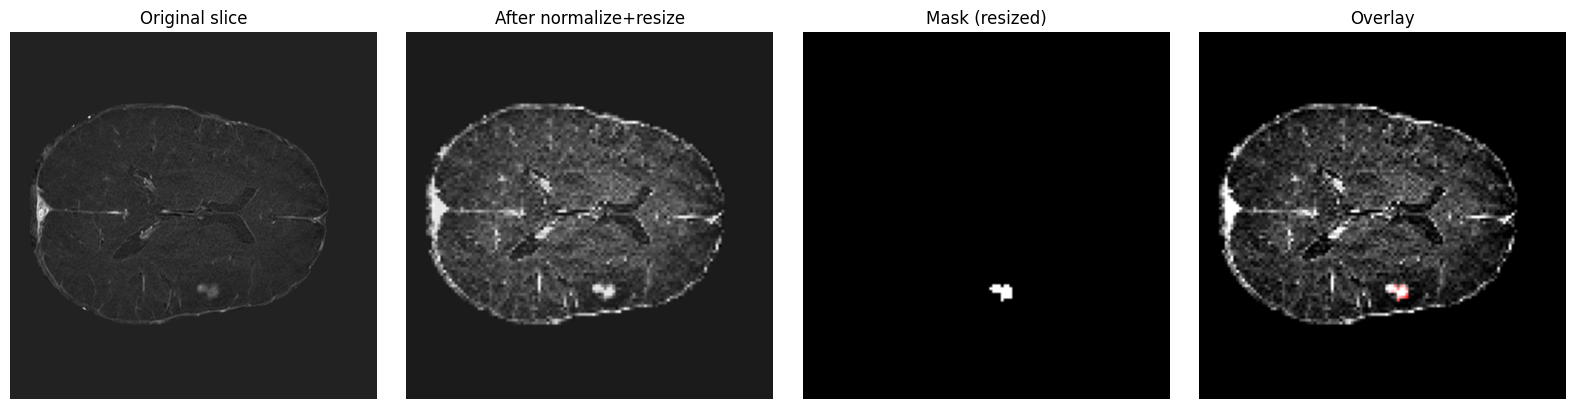

In [3]:
# Choose a patient + slice that has a lesion
patient_id = "100106A"   
slice_idx = 17                 

orig, img_norm, img_resized, img_drr, mask = preprocessor.process_single_slice(
    patient_id=patient_id,
    slice_idx=slice_idx,
    use_clahe=False,   # start with False to remove grain
)

# Quick 4-panel visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(orig, cmap="gray")
axes[0].set_title("Original slice")
axes[0].axis("off")

axes[1].imshow(img_resized, cmap="gray")
axes[1].set_title("After normalize+resize")
axes[1].axis("off")

axes[2].imshow(mask, cmap="gray")
axes[2].set_title("Mask (resized)")
axes[2].axis("off")

overlay = np.stack([img_resized]*3, axis=-1)
overlay[mask > 0, 0] = 1.0  # red overlay on lesions
axes[3].imshow(overlay)
axes[3].set_title("Overlay")
axes[3].axis("off")

plt.tight_layout()
plt.show()